In [2]:
import json
import numpy as np
import pandas as pd
import collections
import nltk
import itertools

Load previous cleaned JSON file.

In [3]:
with open('comments_cleaned.json', 'r') as fp:
    loaded_data = json.load(fp)

Load car brand and model look up.

In [4]:
model_lookup = pd.read_csv('models.csv',header=None)

In [5]:
model_lookup.shape

(531, 2)

In [6]:
brands_np = model_lookup.iloc[:,0].unique()
model_np = model_lookup.iloc[:,1].unique()
len(model_np)

526

In [7]:
[item for item, count in collections.Counter(model_lookup.iloc[:,1]).items() if count > 1]

['Legend', 'Matrix', 'optima', 'passat']

Note that we have model names that's associated with two brands.

In [8]:
loaded_data.keys()

dict_keys(['page', 'comment_id', 'user_id', 'date', 'comment', 'comment_tokenized', 'tagged_filtered_sentence'])

Select the first 5000 comments. Transform tagged sentences, keep only singular nouns.

In [9]:
tagged_sentences = loaded_data['tagged_filtered_sentence'][:5000]

In [10]:
tagged_sentences_lower = []
noun_tags = ['FW','NN','NNS','NNP','NNPS','SYM']
stemmer = nltk.PorterStemmer()
for sentence in tagged_sentences:
    new_sentence = []
    for word_t in sentence:
        if word_t[1] in noun_tags:
            if word_t[1] == 'NNS':
                word_t[0] = stemmer.stem(word_t[0])
                word_t[1] = 'NN'
            elif word_t[1] == 'NNPS':
                word_t[0] = stemmer.stem(word_t[0])
                word_t[1] = 'NNP'
            new_sentence.append(word_t[0])
    tagged_sentences_lower.append(new_sentence)

In [11]:
tagged_sentences_lower[8]

['RX-8',
 'G35',
 'coupe',
 'Saturn',
 'ION',
 'coupe',
 'door',
 'S40',
 'size',
 'Mazda3',
 'Focus.I',
 'sedan',
 'title',
 'Compass',
 'wagon',
 'SUV']

In [12]:
loaded_data['comment'][8]

'I wouldn\'t consider the RX-8, G35 coupe, or Saturn ION coupe to be midsized, no matter how many doors they have. I don\'t think the S40 is midsized either, being the same size as a Mazda3 or Focus.I think since "sedans" is in the title, the Compass (which is too small to be midsized anyway), wagons shouldn\'t count, gloried as a wanna-be SUV or not. '

Count the appearence of each brand for each of the comment.

Assumptions:

If we observed a model that has more than two associated brands:
- check if one of the associated brand has been captured, this model would then count under that brand
- if no information is captured, count this model under the brand that appears first in the look up table in alphabet order

In [32]:
def get_brand(sentence):
    result = []
    # lower case all strings
    sentence_lower = [x.lower() for x in sentence]
    # drop duplicates
    sentence_lower = list(dict.fromkeys(sentence_lower))
    # go through the list of car brands
    for brand in brands_np:
        if brand.lower() in sentence_lower:
            if brand.lower() not in result:
                result.append(brand.lower())
    # go through the model list, retraive brand info
    for i,model in enumerate(model_lookup.iloc[:,1]):
        candidate_brands = []
        for j,word in enumerate(sentence_lower):
            if model.lower() == word:
                candidate_brands.append(model_lookup.iloc[i,0])
        if len(candidate_brands) == 1 and candidate_brands[0].lower() not in result:
            result.append(candidate_brands[0].lower())
        elif len(candidate_brands) > 1:
            flg = 0
            for brand_c in candidate_brands:
                if brand_c in result:
                    flg += 1
            if flg == 0:
                result.append(candidate_brands[0].lower())
                    
    return result
                    
            

In [34]:
get_brand(tagged_sentences_lower[8])

['saturn', 'sedan', 'ford', 'mazda']

In [35]:
brands_in_comments = list(map(lambda x: get_brand(x), tagged_sentences_lower))

In [25]:
len(brands_in_comments)

5000

In [26]:
brands_in_comments[4]

['car',
 'ford',
 'hyundai',
 'kia',
 'mazda',
 'nissan',
 'seat',
 'honda',
 'saturn',
 'toyota']

In [27]:
lst_of_brands_comments = list({x for l in brands_in_comments for x in l})

In [28]:
len(lst_of_brands_comments)

30

Brands info is extracted from each comment, with one brand only counted once. Now under each brand we count its appearance.

In [29]:
brand_count = [0]*len(lst_of_brands_comments)
for i,brand in enumerate(lst_of_brands_comments):
    for comment_info in brands_in_comments:
        if brand in comment_info:
            brand_count[i] += 1
                

In [30]:
sorted_brand_count = pd.DataFrame({'brand':lst_of_brands_comments,'count':brand_count}).sort_values(by='count',ascending=False).reset_index(drop=True)
sorted_brand_count.to_csv('brand_count.csv',index=False)

In [31]:
sorted_brand_count.head(10)

,brand,count
0,car,2331
1,honda,2061
2,ford,1339
3,toyota,937
4,hyundai,576
5,mazda,552
6,nissan,514
7,sedan,408
8,problem,343
9,chevrolet,235


## Brand Association and lift

We need to remove terms that are not brands first, e.g., car, sedan, seat, problem

In [25]:
remove_terms = ['car','problem','sedan','seat']
lst_of_brands = [x for x in lst_of_brands_comments if x not in remove_terms]

In [26]:
len(lst_of_brands)

26

In [27]:
combos = list(itertools.combinations(lst_of_brands, 2))

In [28]:
combos_count = [0] * len(combos)
brand_1 = []
brand_2 = []
for i,c in enumerate(combos):
    brand_1.append(c[0])
    brand_2.append(c[1])
    for brands in brands_in_comments:
        if c[0] in brands and c[1] in brands:
            combos_count[i] += 1

In [29]:
mention_combo = pd.DataFrame({'brand1':brand_1,'brand2':brand_2,'count':combos_count})
mention_combo

,brand1,brand2,count
0,nissan,toyota,220
1,nissan,chevrolet,50
2,nissan,saturn,75
3,nissan,subaru,33
4,nissan,ford,165
...,...,...,...
320,cadillac,mercury,0
321,cadillac,suzuki,0
322,volkswagen,mercury,7
323,volkswagen,suzuki,0


In [30]:
full_count_1 = mention_combo.merge(sorted_brand_count, left_on='brand1', right_on='brand',suffixes=('_joint', '_brand1')).drop(columns=['brand'])
full_count_1

,brand1,brand2,count_joint,count_brand1
0,nissan,toyota,220,514
1,nissan,chevrolet,50,514
2,nissan,saturn,75,514
3,nissan,subaru,33,514
4,nissan,ford,165,514
...,...,...,...,...
320,cadillac,mercury,0,25
321,cadillac,suzuki,0,25
322,volkswagen,mercury,7,100
323,volkswagen,suzuki,0,100


In [31]:
N = 5000
full_count = full_count_1.merge(sorted_brand_count, left_on='brand2', right_on='brand').drop(columns=['brand'])
full_count.columns = list(full_count.columns)[:-1] + ['count_brand2']
full_count['lift'] = (full_count.count_joint/(full_count.count_brand1*full_count.count_brand2)) * N
full_count

,brand1,brand2,count_joint,count_brand1,count_brand2,lift
0,nissan,toyota,220,514,937,2.283968
1,nissan,chevrolet,50,514,235,2.069708
2,toyota,chevrolet,82,937,235,1.861986
3,nissan,saturn,75,514,231,3.158320
4,toyota,saturn,104,937,231,2.402436
...,...,...,...,...,...,...
320,volvo,suzuki,0,30,8,0.000000
321,mercedes,suzuki,0,26,8,0.000000
322,cadillac,suzuki,0,25,8,0.000000
323,volkswagen,suzuki,0,100,8,0.000000


In [32]:
full_count.loc[full_count.brand1 == 'mercedes',:]

,brand1,brand2,count_joint,count_brand1,count_brand2,lift
252,mercedes,cadillac,1,26,25,7.692308
274,mercedes,volkswagen,1,26,100,1.923077
297,mercedes,mercury,1,26,81,2.374169
321,mercedes,suzuki,0,26,8,0.000000


In [33]:
full_count.to_csv('count_and_lift.csv',index=False)

Construct a dissimilarity matrix with lift.

In [34]:
full_count = pd.read_csv('count_and_lift.csv')

In [35]:
full_count.head()

,brand1,brand2,count_joint,count_brand1,count_brand2,lift
0,nissan,toyota,220,514,937,2.283968
1,nissan,chevrolet,50,514,235,2.069708
2,toyota,chevrolet,82,937,235,1.861986
3,nissan,saturn,75,514,231,3.158320
4,toyota,saturn,104,937,231,2.402436


In [44]:
def construct_dissimilarity_matrix(df,brand_lst):
    lift_matrix = {}
    for brand_a in brand_lst:
        #print('A:',brand_a)
        lift_matrix[brand_a] = []
        sub_lift_df1 = df[df.brand1 == brand_a]
        for brand_b in brand_lst:
            #print('B:',brand_b)
            sub_lift_df2 = sub_lift_df1[sub_lift_df1.brand2 == brand_b]
            if len(sub_lift_df2) == 0:
                #try opposite order combo
                sub_lift_df3 = df[df.brand2 == brand_a]
                sub_lift_df4 = sub_lift_df3[sub_lift_df3.brand1 == brand_b]
                if len(sub_lift_df4) > 0:
                    value_0 = sub_lift_df4['lift'].values[0]
                    if value_0 != 0:
                        lift_matrix[brand_a].append(1/value_0)
                    else:
                        lift_matrix[brand_a].append(value_0)
                else:
                    lift_matrix[brand_a].append(0)
            else:
                value_1 = sub_lift_df2['lift'].values[0]
                if value_1 != 0:
                    lift_matrix[brand_a].append(1/value_1)
                else:
                    lift_matrix[brand_a].append(value_1)
    return lift_matrix

In [45]:
dissimilarity_df = pd.DataFrame(construct_dissimilarity_matrix(full_count,lst_of_brands))

In [46]:
dissimilarity_df

,nissan,toyota,chevrolet,saturn,subaru,ford,mitsubishi,mazda,honda,lincoln,...,buick,kia,infiniti,bmw,volvo,mercedes,cadillac,volkswagen,mercury,suzuki
0,0.000000,0.437835,0.483160,0.316624,0.476618,0.834238,0.675543,0.637591,0.679073,2.313000,...,0.390640,0.616800,0.342667,0.740160,0.771000,0.890933,1.285000,0.354483,0.438253,0.41120
1,0.437835,0.000000,0.537061,0.416244,0.796450,0.710846,1.231486,1.100477,0.580799,1.204714,...,0.445075,0.634277,0.374800,0.578263,0.937000,1.218100,0.780833,0.646207,0.489658,0.00000
2,0.483160,0.537061,0.000000,0.169641,0.599250,0.749202,0.308857,1.128000,0.733841,0.000000,...,0.157588,0.564000,0.470000,0.725143,0.705000,0.407333,0.146875,0.391667,0.423000,0.00000
3,0.316624,0.416244,0.169641,0.000000,0.642600,0.736450,1.062600,0.944533,0.743892,2.079000,...,0.188100,0.358729,0.000000,0.997920,0.693000,1.201200,0.192500,0.462000,0.287862,0.00000
4,0.476618,0.796450,0.599250,0.642600,0.000000,1.241618,0.201086,0.312800,0.741960,1.377000,...,0.581400,0.577029,0.000000,1.101600,0.306000,0.000000,0.000000,0.382500,0.309825,0.00000
5,0.834238,0.710846,0.749202,0.736450,1.241618,0.000000,0.947600,0.835173,0.853069,0.286929,...,0.803400,0.883740,2.678000,1.606800,0.472588,0.773644,1.339000,1.115833,0.344314,0.42848
6,0.675543,1.231486,0.308857,1.062600,0.201086,0.947600,0.000000,0.634800,1.458554,0.000000,...,0.524400,0.080960,0.000000,0.993600,0.276000,0.000000,0.000000,0.230000,0.248400,0.00000
7,0.637591,1.100477,1.128000,0.944533,0.312800,0.835173,0.634800,0.000000,0.861873,0.828000,...,0.629280,1.324800,1.104000,0.701365,0.368000,2.870400,0.920000,0.613333,0.496800,0.00000
8,0.679073,0.580799,0.733841,0.743892,0.741960,0.853069,1.458554,0.861873,0.000000,1.854900,...,0.939816,0.777291,0.824400,0.872894,1.030500,0.893100,1.288125,0.777736,0.834705,1.09920
9,2.313000,1.204714,0.000000,2.079000,1.377000,0.286929,0.000000,0.828000,1.854900,0.000000,...,0.000000,0.000000,0.000000,0.972000,0.270000,0.000000,0.000000,0.000000,0.052071,0.07200


In [47]:
from sklearn.manifold import MDS
from matplotlib import pyplot as plt

mds = MDS(n_components=2,random_state=0, dissimilarity='precomputed')
data_transformed = mds.fit_transform(dissimilarity_df)
data_transformed

array([[-0.56448337, -0.09060099],
       [-0.31266541, -0.35390767],
       [ 0.00925571, -0.17215283],
       [-0.37243863, -0.18286873],
       [-0.31947695,  0.20601966],
       [ 0.09909356, -0.8363492 ],
       [ 0.26814622,  0.08167765],
       [-0.75749197,  0.33061903],
       [-0.62088938, -0.50547113],
       [ 0.41561052,  0.21750226],
       [ 0.13254353,  0.43991069],
       [-0.17656828, -0.56377548],
       [ 0.40681053,  0.07971822],
       [ 0.08127662,  0.12504981],
       [ 0.21603707,  0.17443466],
       [ 0.47551149, -0.53921802],
       [ 0.0290594 ,  0.16951769],
       [ 0.22346361, -0.10804992],
       [ 0.10197416,  0.19473529],
       [ 0.06694968,  0.37833671],
       [ 0.15920082,  0.15392209],
       [ 0.31787076,  0.19582074],
       [ 0.15986914,  0.19812972],
       [-0.08761456,  0.27244461],
       [ 0.00556942,  0.0669128 ],
       [ 0.04338632,  0.06764233]])

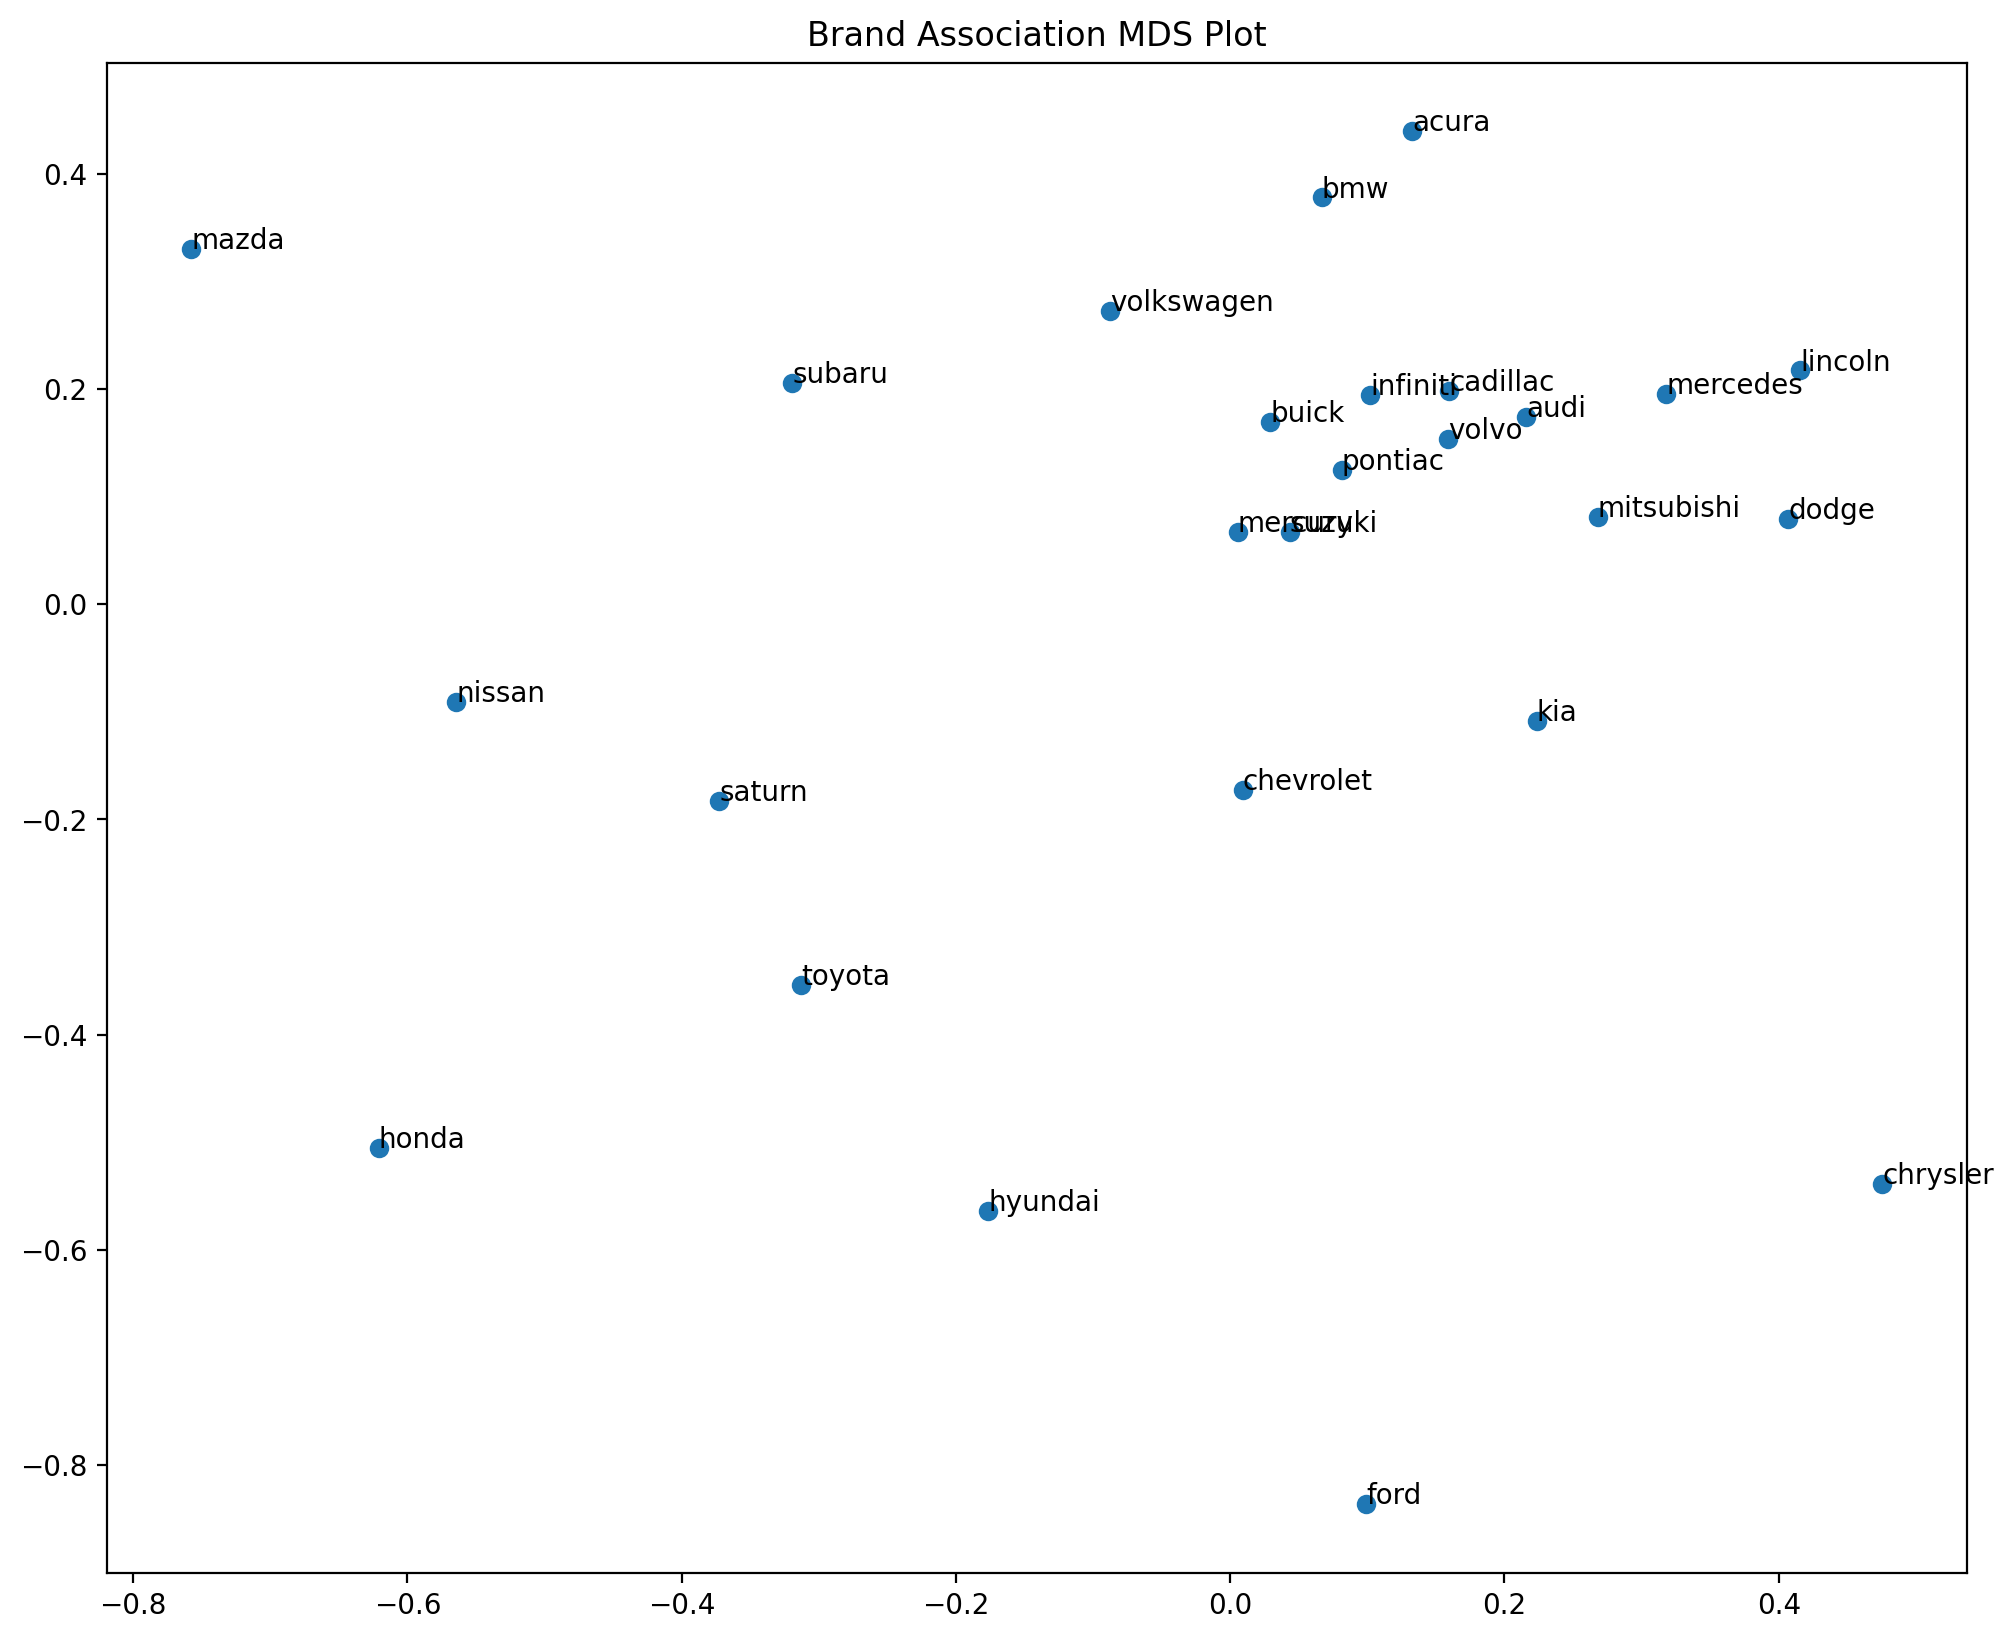

In [48]:
from matplotlib.pyplot import figure
figure(figsize=(12, 10), dpi=200)
plt.scatter(data_transformed[:,0],data_transformed[:,1])
plt.title('Brand Association MDS Plot')
for i, txt in enumerate(lst_of_brands):
    plt.annotate(txt, (data_transformed[i,0], data_transformed[i,1]))
plt.show()

Top 10 brand association

In [53]:
top_10 = sorted_brand_count[~sorted_brand_count.brand.isin(remove_terms)].head(10).reset_index(drop=True)
top_10

,brand,count
0,honda,2061
1,ford,1339
2,toyota,937
3,hyundai,576
4,mazda,552
5,nissan,514
6,chevrolet,235
7,saturn,231
8,chrysler,211
9,subaru,153


In [54]:
top10_brand_lst = top_10.brand.to_list()

In [55]:
top10_brand_lst

['honda',
 'ford',
 'toyota',
 'hyundai',
 'mazda',
 'nissan',
 'chevrolet',
 'saturn',
 'chrysler',
 'subaru']

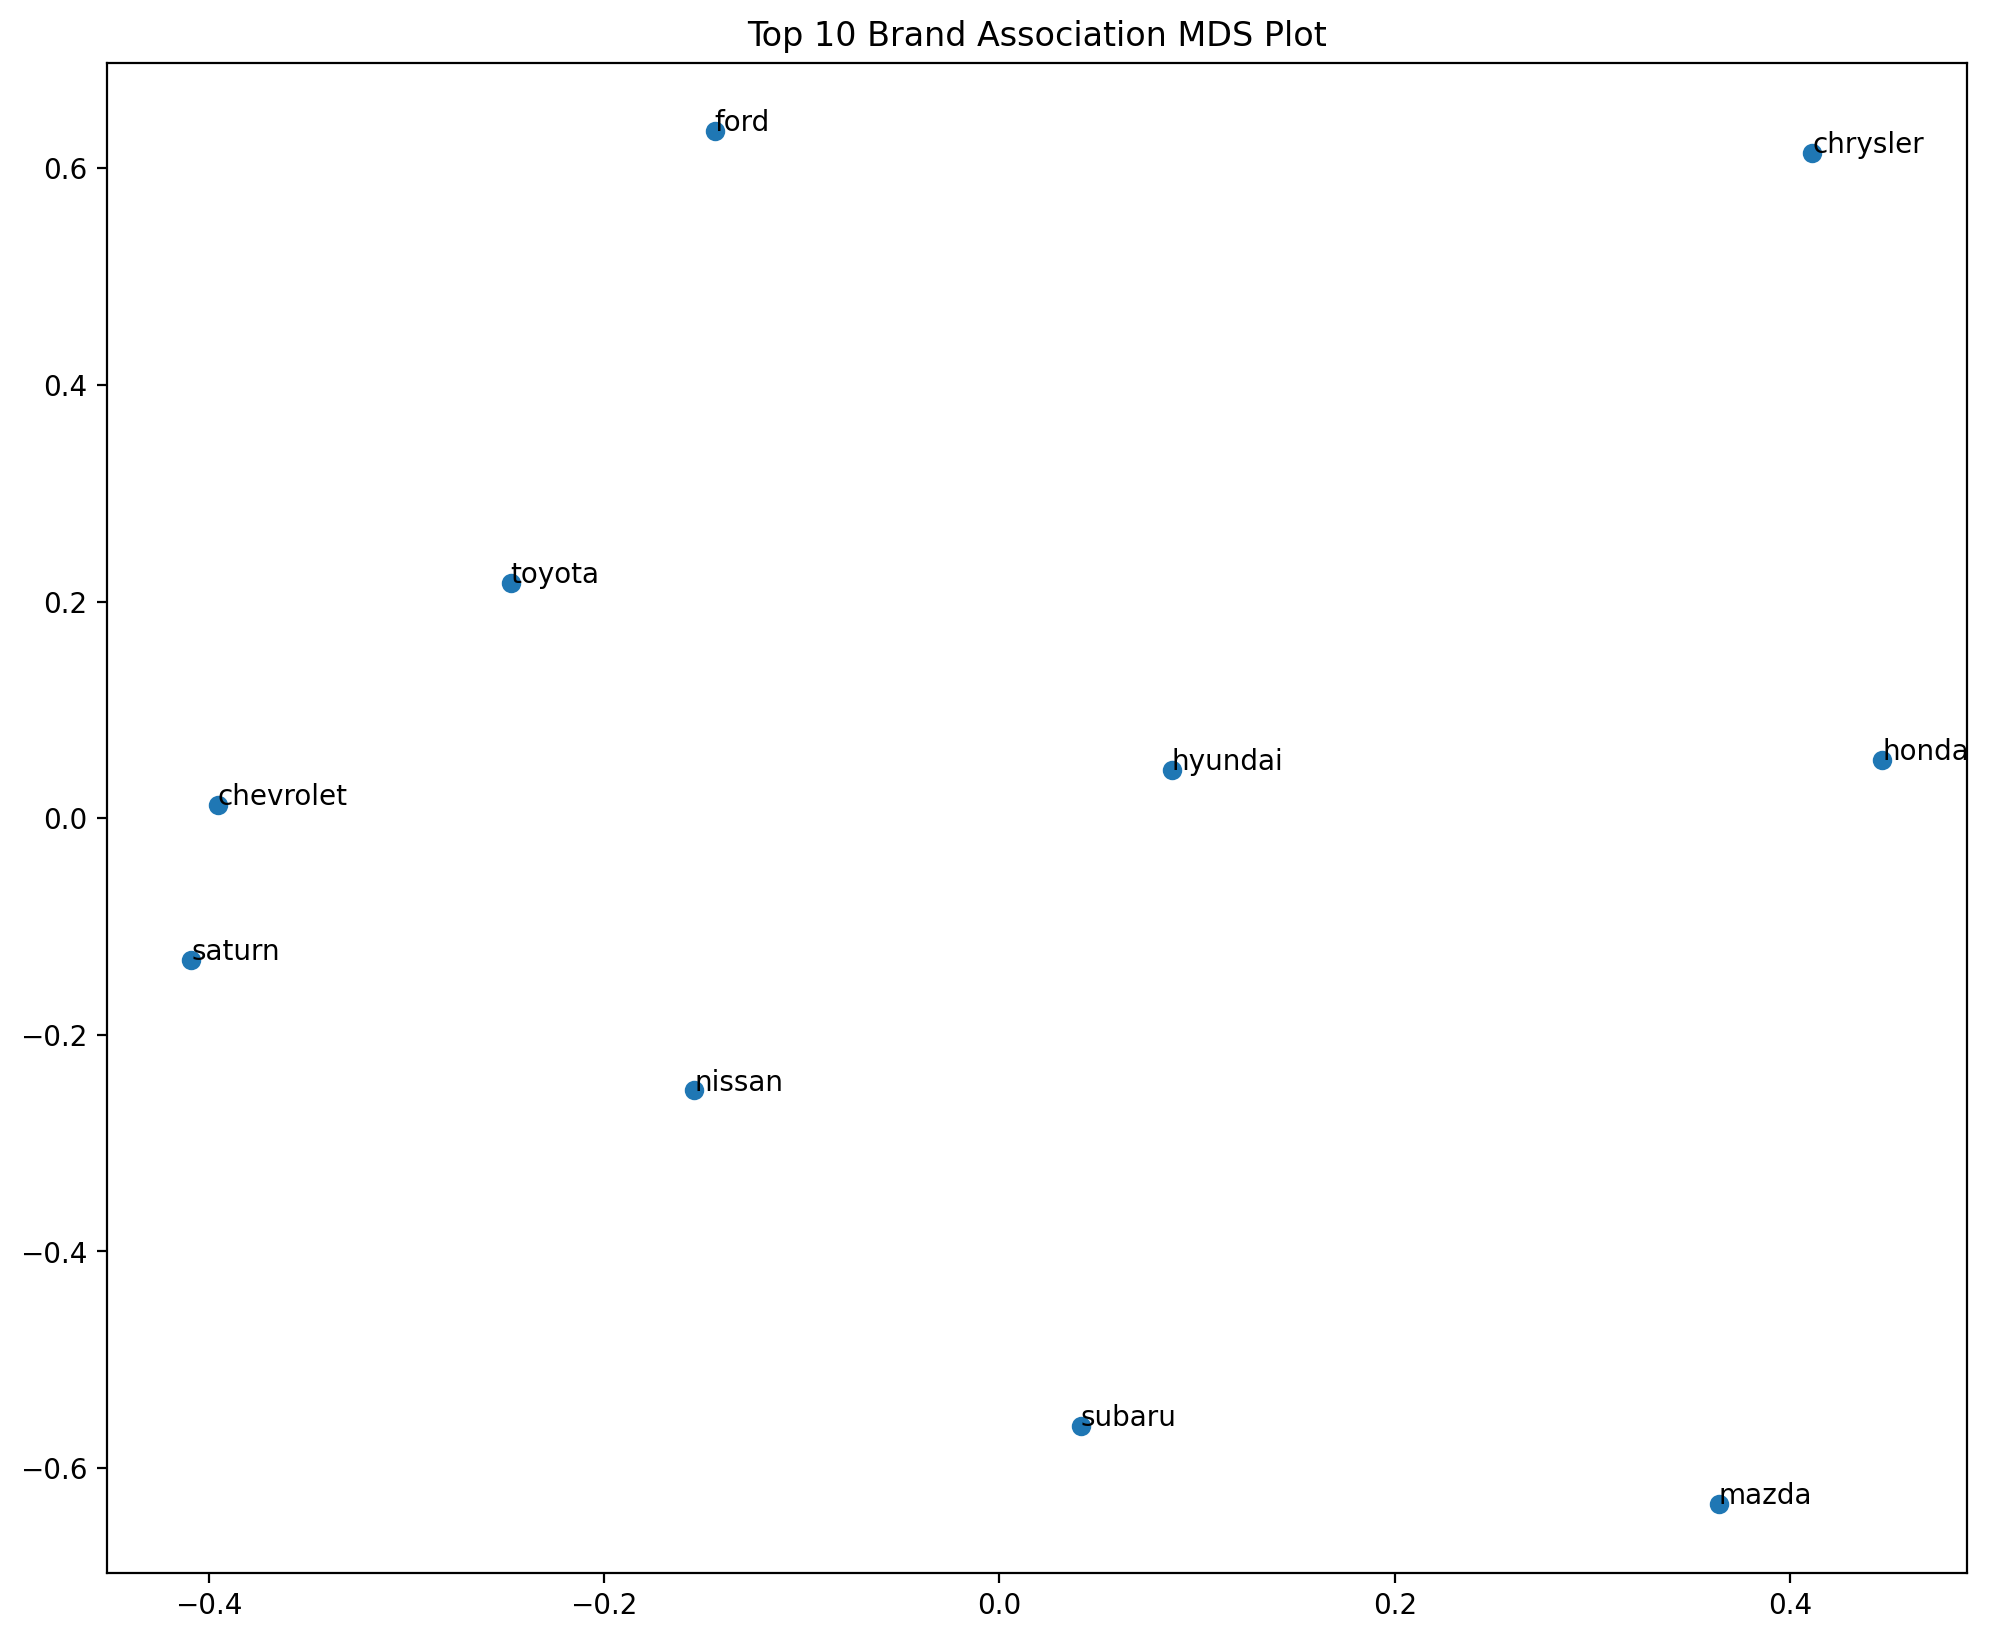

In [59]:
dissimilarity_top10 = pd.DataFrame(construct_dissimilarity_matrix(full_count,top10_brand_lst))
mds_top10 = MDS(n_components=2,random_state=0, dissimilarity='precomputed')
data_transformed_top10 = mds_top10.fit_transform(dissimilarity_top10)
figure(figsize=(12, 10), dpi=200)
plt.scatter(data_transformed_top10[:,0],data_transformed_top10[:,1])
plt.title('Top 10 Brand Association MDS Plot')
for i, txt in enumerate(top10_brand_lst):
    plt.annotate(txt, (data_transformed_top10[i,0], data_transformed_top10[i,1]))
plt.show()